In [1]:
import pandas as pd
import pymc as pm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import statsmodels.api as sm

import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from scipy.special import expit

import os
cwd = os.getcwd()
print("Current working directory:", cwd)






Current working directory: /Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/covvfit/examples


In [2]:
import sys

# Modify this path to match your directory structure
path_to_covvfit = os.path.abspath(os.path.join(cwd, '../src'))
sys.path.append(path_to_covvfit)

# Now you can import your modules
from covvfit import *

In [61]:
variants_full = [
    'B.1.1.7', 'B.1.351', 'P.1',
    'B.1.617.2', 'BA.1', 'BA.2', 'BA.4', 'BA.5', 'BA.2.75',
    'BQ.1.1',
    'XBB.1.5', 'XBB.1.9', 'XBB.1.16', 'XBB.2.3', 'EG.5', "BA.2.86", "JN.1"
]

variants = [
    'XBB.1.5', 'XBB.1.9', 'XBB.1.16', 'XBB.2.3', 'EG.5', "BA.2.86", "JN.1"
]

variants_other = [i for i in variants_full if i not in variants]


cities = ['Lugano (TI)', 'Zürich (ZH)', 'Chur (GR)', 'Altenrhein (SG)',
       'Laupen (BE)', 'Genève (GE)', 'Basel (BS)', 'Porrentruy (JU)',
       'Lausanne (VD)', 'Bern (BE)', 'Luzern (LU)', 'Solothurn (SO)',
       'Neuchâtel (NE)', 'Schwyz (SZ)']

colors_covsp = {
  'B.1.1.7': '#D16666',
  'B.1.351': '#FF6666',
  'P.1': '#FFB3B3',
  'B.1.617.1': '#66C265',
  'B.1.617.2': '#66A366',
  'BA.1': '#A366A3',
  'BA.2': '#CFAFCF',
  'BA.4': '#8a66ff',
  'BA.5': '#585eff',
  'BA.2.75': '#008fe0',
  'BQ.1.1': '#ac00e0',
  'XBB.1.9': '#bb6a33',
  'XBB.1.5': '#ff5656',
  'XBB.1.16': '#e99b30',
  'XBB.2.3': '#f5e424', 
  'EG.5': '#b4e80b', 
  'BA.2.86': '#FF20E0',
  "JN.1" : "#00e9ff", #improv
  'undetermined': '#969696',
}

In [26]:
data = load_data('../data/robust_deconv2_noisy14.csv')
variants2 = ['other'] + variants 
data2 = preprocess_df(data, cities, variants_full, date_min='2023-04-01')
data2["other"] = data2[variants_other].sum(axis=1)
data2[variants2] = data2[variants2].div(data2[variants2].sum(axis=1), axis=0)

ts_lst, ys_lst = make_data_list(data2, cities, variants2)
ts_lst, ys_lst2 = make_data_list(data2, cities, variants)

In [25]:
## This model takes into account the complement of the variants to be monitored, and sets its fitness to zero
## However, due to the pm.math.concatenate operation, we cannot use it for finding the hessian

def create_model_fixed2(
    ts_lst,
    ys_lst,
    n=1.0,
    coords={
        "cities":[],
        "variants":[],
    },
    n_pred=60
):
    """function to create a fixed effect model with varying intercepts and one rate vector"""
    with pm.Model(coords=coords) as model:
        midpoint_var = pm.Normal("midpoint", mu=0.0, sigma=300.0, dims=["cities", "variants"])
        rate_var = pm.Gamma("rate", mu=0.15, sigma=0.1, dims="variants")
        
        # Kaan's trick to avoid overflows
        def softmax(x, rates, midpoints):
            E = rates[:, None] * x + midpoints[:, None]
            E_max = E.max(axis=0)
            un_norm = pm.math.exp(E - E_max)
            return un_norm / (pm.math.sum(un_norm, axis=0))
        
        ys_smooth = [softmax(
            ts_lst[i],
            pm.math.concatenate([[0], rate_var]),
            pm.math.concatenate([[0], midpoint_var[i,:]]),
        ) for i, city in enumerate(coords["cities"])]
        
        # make Multinom/n likelihood
        def log_likelihood(y, p, n):
            # return n*pm.math.sum(y * pm.math.log(p), axis=0) + n*(1-pm.math.sum(y, axis=0))*pm.math.log(1-pm.math.sum(p, axis=0))
            return n*pm.math.sum(y * pm.math.log(p), axis=0)

        ys_noisy = [pm.DensityDist(
                        f"ys_noisy_{city}",
                        ys_smooth[i],
                        n,
                        logp=log_likelihood,
                        observed=ys_lst[i],
        ) for i, city in enumerate(coords["cities"])]        
        
    return model

In [27]:
with create_model_fixed2(ts_lst, ys_lst, coords={
        "cities":cities,
        "variants":variants,
    }):
    model_map_fixed = pm.find_MAP(maxeval=50000, seed=12313)

In [29]:
## This model takes into account the complement of the variants to be monitored, and sets its fitness to zero
## It has some numerical instabilities that make it not suitable for finding the MAP or MLE, but I use it for the Hessian

def create_model_fixed3(
    ts_lst,
    ys_lst,
    n=1.0,
    coords={
        "cities":[],
        "variants":[],
    },
    n_pred=60
):
    """function to create a fixed effect model with varying intercepts and one rate vector"""
    with pm.Model(coords=coords) as model:
        midpoint_var = pm.Normal("midpoint", mu=0.0, sigma=1500.0, dims=["cities", "variants"])
        rate_var = pm.Gamma("rate", mu=0.15, sigma=0.1, dims="variants")
        
        # Kaan's trick to avoid overflows
        def softmax_1(x, rates, midpoints):
            E = rates[:, None] * x + midpoints[:, None]
            E_max = E.max(axis=0)
            un_norm = pm.math.exp(E - E_max)
            return un_norm / (pm.math.exp(-E_max) + pm.math.sum(un_norm, axis=0))
        
        ys_smooth = [softmax_1(ts_lst[i], rate_var, midpoint_var[i,:]) for i, city in enumerate(coords["cities"])]
        
        # make Multinom/n likelihood
        def log_likelihood(y, p, n):
            return n*pm.math.sum(y * pm.math.log(p), axis=0) + n*(1-pm.math.sum(y, axis=0))*pm.math.log(1-pm.math.sum(p, axis=0))
#             return n*pm.math.sum(y * pm.math.log(p), axis=0)

        ys_noisy = [pm.DensityDist(
                        f"ys_noisy_{city}",
                        ys_smooth[i],
                        n,
                        logp=log_likelihood,
                        observed=ys_lst[i],
        ) for i, city in enumerate(coords["cities"])]        
        
    return model

In [30]:
with create_model_fixed3(ts_lst, ys_lst2, coords={
        "cities":cities,
        "variants":variants,
    }):
    model_hessian_fixed = pm.find_hessian(
        model_map_fixed
    )

In [31]:
y_fit_lst = fitted_values(ts_lst, model_map_fixed, cities)

In [56]:
ts_pred_lst, y_pred_lst = pred_values([i.max()-1 for i in ts_lst], model_map_fixed, cities, horizon=60)

In [33]:
pearson_r_lst, overdisp_list, overdisp_fixed = compute_overdispersion(ys_lst2, y_fit_lst, cities)

In [34]:
fitness_diff, fitness_diff_se, fitness_diff_lower, fitness_diff_upper = make_fitness_confints(model_map_fixed['rate'], model_hessian_fixed, overdisp_fixed, g=7.0)

## Plot

/Users/gneiss/miniconda3/envs/pymc_env/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


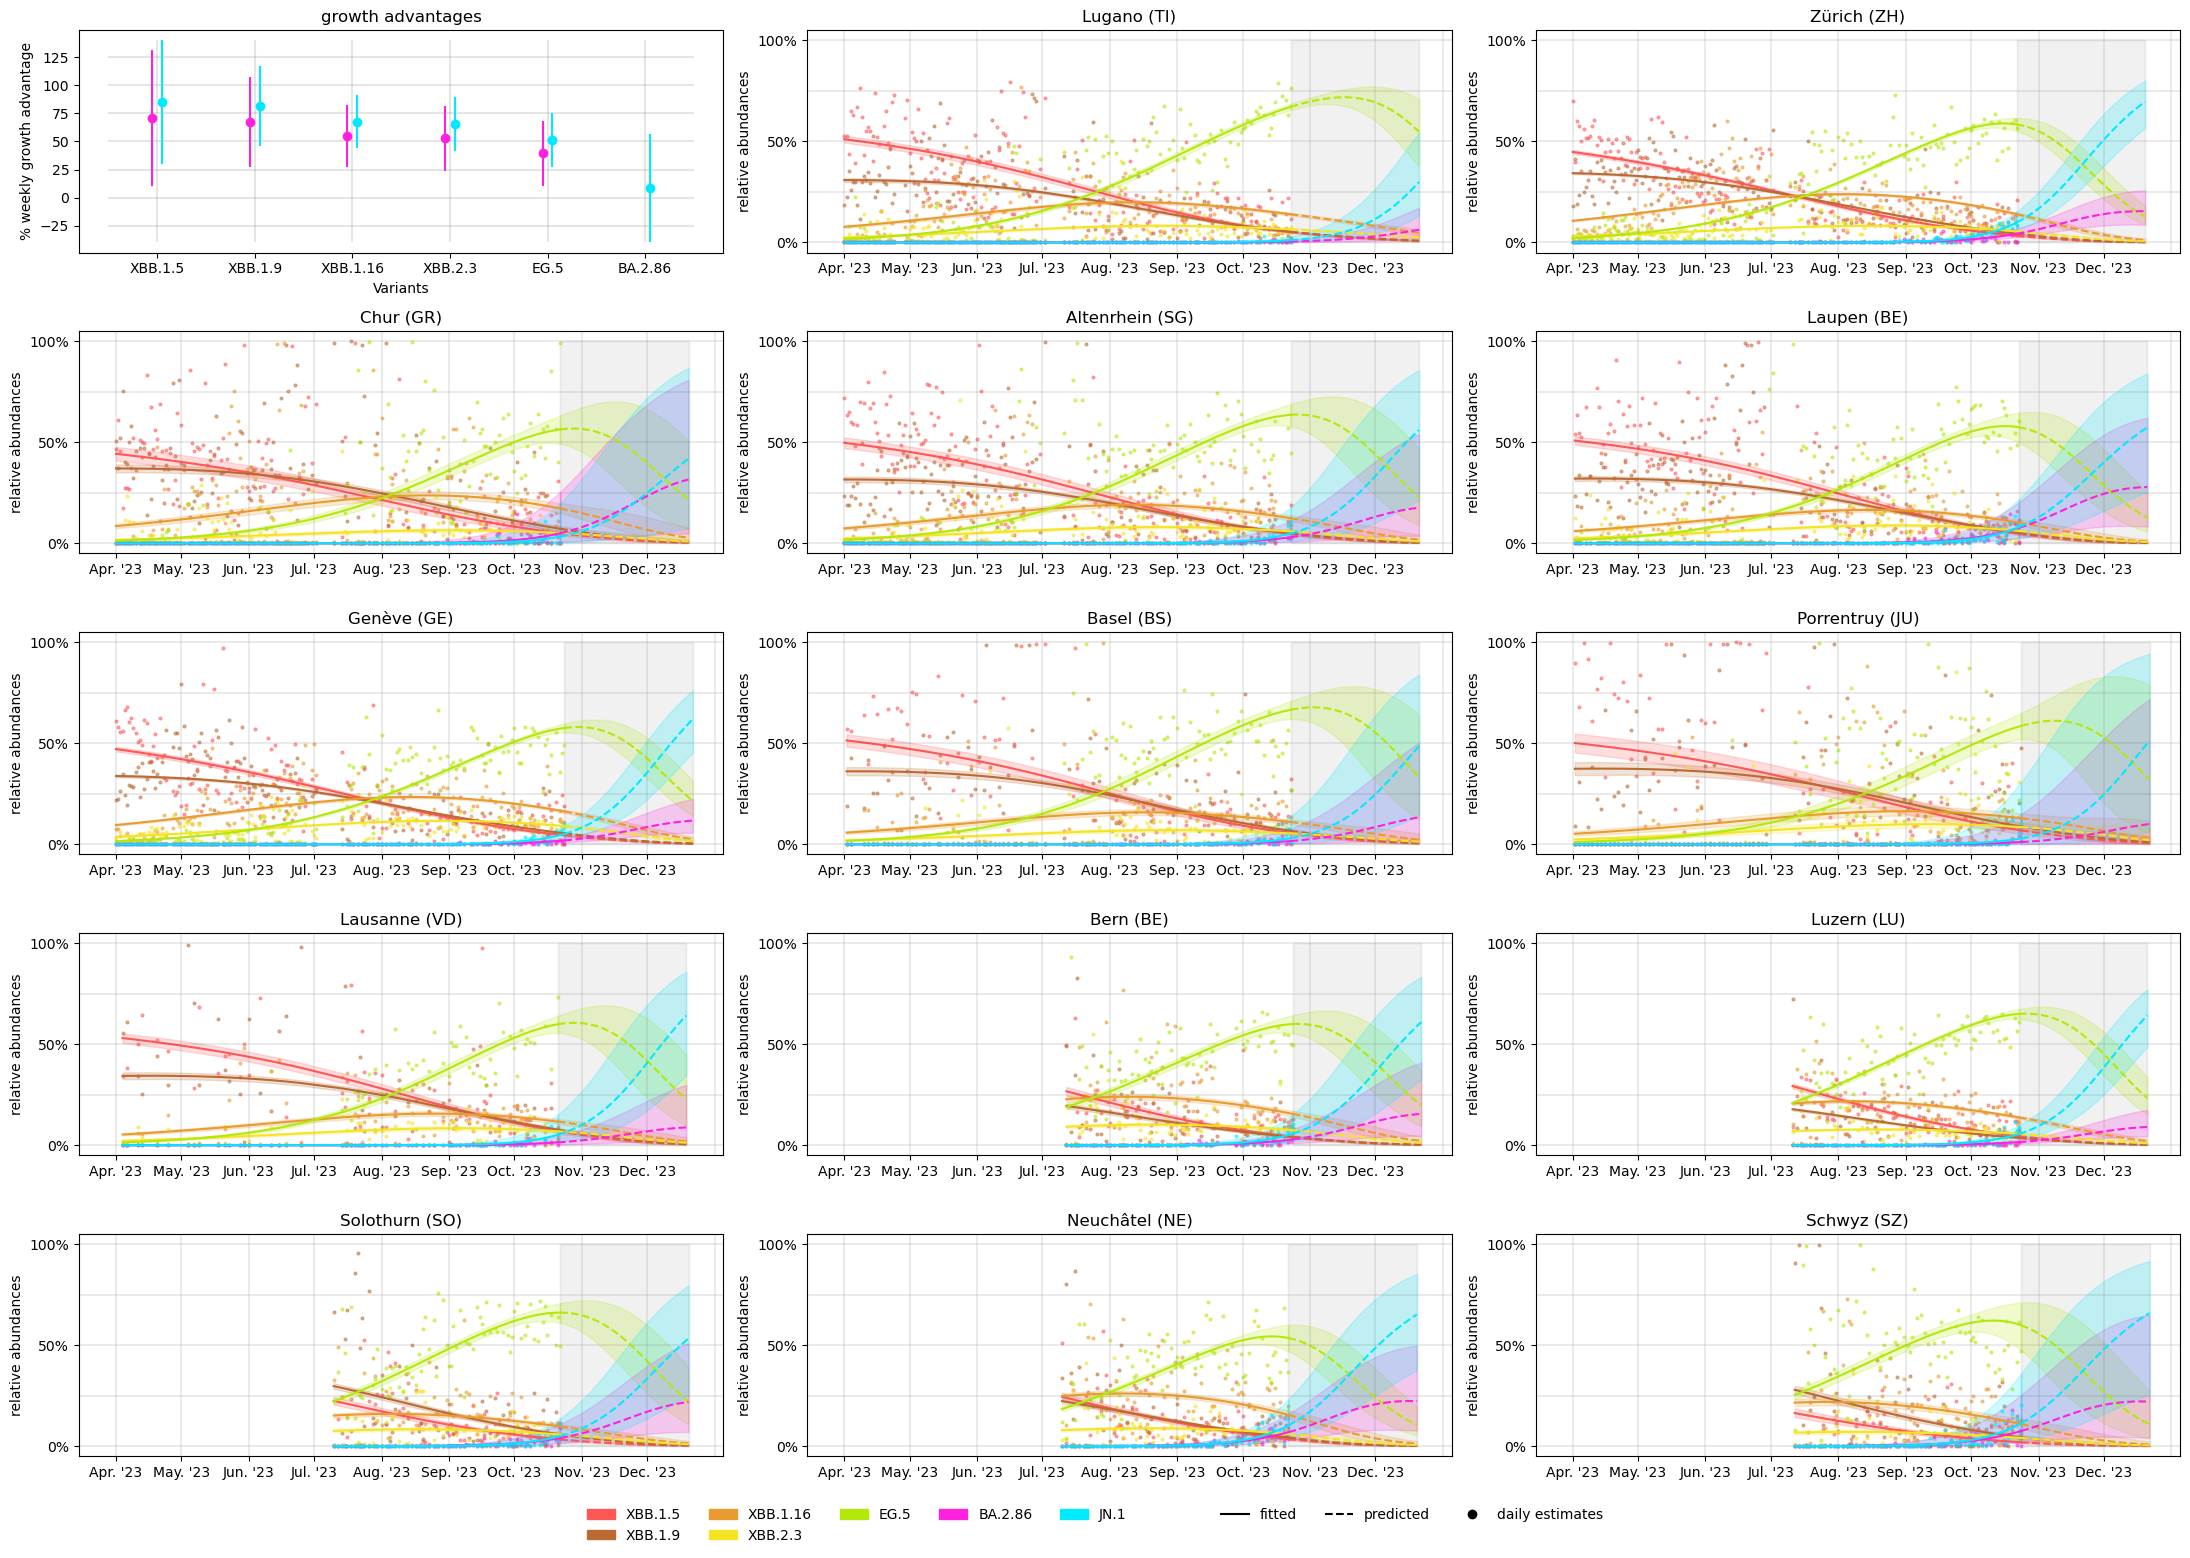

In [62]:
fig, axes_tot = plt.subplots(5,3,figsize=(22,15))
# colors = default_cmap = plt.cm.get_cmap('tab10').colors
colors = [colors_covsp[var] for var in variants]
# axes=[axes_tot]
axes=axes_tot.flatten()
p_variants = len(variants)
p_params = model_hessian_fixed.shape[0]
model_hessian_inv = np.linalg.inv(model_hessian_fixed)

for k, city in enumerate(cities):
    ax = axes[k+1]
    y_fit = y_fit_lst[k]
    ts=ts_lst[k]
    ts_pred = ts_pred_lst[k]
    y_pred = y_pred_lst[k]
    ys = ys_lst2[k]
    hessian_indices = np.concatenate([np.arange(p_variants) + k*p_variants, np.arange(model_hessian_fixed.shape[0] - p_variants, p_params)])
    tmp_hessian = model_hessian_inv[hessian_indices,:][:,hessian_indices]
    y_fit_logit = (np.log(y_fit) - np.log(1-y_fit))
    logit_se = np.array([project_se(model_map_fixed['rate'], model_map_fixed['midpoint'][k,:], t, tmp_hessian, overdisp_list[k]) for t in ts]).T
    y_pred_logit = (np.log(y_pred) - np.log(1-y_pred))
    logit_se_pred = np.array([project_se(model_map_fixed['rate'], model_map_fixed['midpoint'][k,:], t, tmp_hessian, overdisp_list[k]) for t in ts_pred]).T

    for i, variant in enumerate(variants):

        # grid
        ax.vlines(x=(pd.date_range(start='2021-11-01', end='2024-02-01', freq='MS')- pd.to_datetime('2023-01-01')).days, 
                  ymin=-0.05, ymax=1.05, color="grey", alpha=0.02)
        ax.hlines(y=[0, 0.25,0.5,0.75, 1], 
                  xmin=(pd.to_datetime('2021-10-10')- pd.to_datetime('2023-01-01')).days, 
                  xmax=(pd.to_datetime('2024-02-20')- pd.to_datetime('2023-01-01')).days,
                  color="grey", alpha=0.02)
        ax.fill_between(x=ts_pred, y1=0, y2=1, color="grey", alpha=0.01)

        # plot fitted
        sorted_indices = np.argsort(ts)
        ax.plot(ts[sorted_indices], y_fit[i,:][sorted_indices], color=colors[i], label="fit")
        # plot pred
        ax.plot(ts_pred, y_pred[i,:], color=colors[i], linestyle="--", label="predict")
#         plot confints
        ax.fill_between(
            ts[sorted_indices],
            expit(y_fit_logit[i,:][sorted_indices] - 1.96 * logit_se[i,:][sorted_indices]),
            expit(y_fit_logit[i,:][sorted_indices] + 1.96 * logit_se[i,:][sorted_indices]),
            color=colors[i], alpha=0.2, label='Confidence band'
        )
        ax.fill_between(
            ts_pred,
            expit(y_pred_logit[i,:] - 1.96 * logit_se_pred[i,:]),
            expit(y_pred_logit[i,:] + 1.96 * logit_se_pred[i,:]),
            color=colors[i], alpha=0.2, label='Confidence band'
        )

        # plot empirical 
        ax.scatter(ts, ys[i,:], label="observed", alpha=0.5, color=colors[i], s=4)

        ax.set_ylim((-0.05,1.05))
        ax.set_xticks((pd.date_range(start='2021-11-01', end='2023-12-01', freq='MS') - pd.to_datetime('2023-01-01')).days)
        date_formatter = ticker.FuncFormatter(num_to_date)
        ax.xaxis.set_major_formatter(date_formatter)
        tick_positions = [0, 0.5, 1]
        tick_labels = ['0%', '50%', '100%']
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
        ax.set_ylabel("relative abundances")
        ax.set_xlim((pd.to_datetime(['2023-03-15', '2024-01-05'])- pd.to_datetime('2023-01-01')).days)
        ax.set_title(f"{city}")

## Plot estimates

ax = axes[0]

fitness_diff, fitness_diff_se, fitness_diff_lower, fitness_diff_upper = make_fitness_confints(model_map_fixed['rate'], model_hessian_fixed, overdisp_fixed, g=7.0)

fitness_diff = fitness_diff * 100
fitness_diff_lower = fitness_diff_lower * 100
fitness_diff_upper = fitness_diff_upper * 100

# Get the indices for the upper triangle, starting at the diagonal (k=0)
upper_triangle_indices = np.triu_indices_from(fitness_diff, k=0)

# Assign np.nan to the upper triangle including the diagonal
fitness_diff[upper_triangle_indices] = np.nan
fitness_diff_lower[upper_triangle_indices] = np.nan
fitness_diff_upper[upper_triangle_indices] = np.nan

fitness_diff[:-2,:] = np.nan
fitness_diff_lower[:-2,:] = np.nan
fitness_diff_upper[:-2,:] = np.nan

# Calculate the error (distance from the point to the error bar limit)
error = np.array([
    fitness_diff - fitness_diff_lower,  # Lower error
    fitness_diff_upper - fitness_diff   # Upper error
])

# Define the width of the offset
offset_width = 0.1
num_sets = fitness_diff.shape[0]
# num_sets = 2
mid = (num_sets - 1) / 2

# grid
ax.vlines(x=np.arange(len(variants)-1), 
          ymin=np.nanmin(fitness_diff_lower), ymax=np.nanmax(fitness_diff_upper),
          color="grey", alpha=0.2)
ax.hlines(y=np.arange(-25, 126, step=25), 
          xmin=-0.5,
          xmax=len(variants)-2+0.5,
          color="grey", alpha=0.2)

# Plot each set of points with error bars
for i, y_vals in enumerate(fitness_diff):
    # Calculate offset for each set
    offset = (i - mid) * offset_width
    # Create an array of x positions for this set
#     x_positions = np.arange(len(variants)) + offset
    x_positions = np.arange(len(variants)) + offset - 0.25
    # We need to transpose the error array to match the shape of y_vals
    ax.errorbar(x_positions, y_vals, yerr=error[:, i, :], fmt='o', label=variants[i], color=colors_covsp[variants[i]])

# Set the x-ticks to be at the middle of the groups of points
ax.set_xticks(np.arange(len(variants)-1))
ax.set_xticklabels(variants[:-1])

# Add some labels and a legend
ax.set_xlabel('Variants')
ax.set_ylabel('% weekly growth advantage')
ax.set_title("growth advantages")




fig.tight_layout()
fig.legend(handles=make_legend(colors, variants), loc = 'lower center', ncol=9, bbox_to_anchor = (0.5, -0.04), frameon=False)


plt.savefig("growth_rates20231108.pdf", bbox_inches='tight')

plt.show()
